# 50.039 Deep Learning Project

Group Members:
- Lee Chang Zheng
- Lee Cheng Xin
- Jason Peng Jing Ming

## Imports and CUDA

In [43]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchaudio import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import librosa

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [45]:
# Set the seed
seed = 12
torch.manual_seed(seed)

## Audio Preprocessing Pipeline

We create a pipeline to streamline the processing of audio. 

In [46]:
import os, shutil, time
class ProcessingPipeline:
    def __init__(self, processes):
        self.processes = processes

    def run_pipeline(self,input_folder, output_folder):
        self.delete_files(output_folder)
        if len(self.processes) == 1:
            process = self.processes[0]
            print(process.__name__)
            process(input_folder, output_folder)
            return
        if not os.path.exists("tmp1"):
            os.makedirs("tmp1")
        if not os.path.exists("tmp2"):
            os.makedirs("tmp2")
        
        curr_folder = "./tmp1"
        next_folder = "./tmp2"
        process = self.processes[0]
        print(process.__name__)
        process(input_folder, curr_folder)
        for i in range(1, len(self.processes) - 1):
            process = self.processes[i]
            self.delete_files(next_folder)
            #swap folders
            print(curr_folder, next_folder)
            print(process.__name__)
            process(curr_folder, next_folder)
            a = curr_folder
            curr_folder = next_folder
            next_folder = a
        process = self.processes[-1]
        print(process.__name__)
        process(curr_folder, output_folder)
        self.delete_files("./tmp1")
        self.delete_files("./tmp2")
        os.rmdir("./tmp1")
        os.rmdir("./tmp2")

    def delete_files(self, folder):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

We perform the 4 operations in order:
1) Conversion of audio to .wav
2) Removal of noise
3) Trimming of silent regions
4) Padding for consistent dimensions

In [47]:
# Convert webm and ogg files to wav with single channel, sample rate of 48000 Hz, padded to 10 seconds long
import subprocess
from pydub import AudioSegment
import os
from silence import trim_silence
from noise_reduction import noise_reduce
def convert_audio(in_path, out_path):
    if '.webm' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.webm', '.wav')])
    elif '.ogg' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.ogg', '.wav')])
    elif '.wav' in in_path:
        subprocess.run(["ffmpeg", "-i", in_path, "-y", "-ac", "1", "-ar", "48000", out_path.replace('.wav', '.wav')])

def pad_trim_audio(in_path, out_path):
    audio = AudioSegment.from_wav(in_path)
    if len(audio) < 10000:
        padding = AudioSegment.silent(duration=10000 - len(audio))
        padded_audio = audio + padding
        padded_audio.export(out_path, format='wav')
    else:
        trimmed_audio = audio[:10000]
        trimmed_audio.export(out_path, format='wav')
    
# Note: These are commented out as the conversion has been done, it is simply for reference. You will need FFmpeg to run this.
# for filename in os.listdir('./Data/Covid'):
#     convert_audio(f'./Data/Covid/{filename}', f'./Converted/{filename}')
# for filename in os.listdir('./Data/Healthy'):
#     convert_audio(f'./Data/Healthy/{filename}', f'./Converted/{filename}')

# # Padding/trimming the audio to 10 seconds long
# for filename in os.listdir('./Converted'):
#     pad_trim_audio(f'./Converted/{filename}', f'./Converted/{filename}')

def pad_folder(in_folder, out_folder):
    for filename in os.listdir(in_folder):
        print("here")
        pad_trim_audio(f'{in_folder}/{filename}', f'{out_folder}/{filename}')

def convert_audio_folder(in_folder, out_folder):
    for filename in os.listdir(in_folder):
        convert_audio(f'{in_folder}/{filename}', f'{out_folder}/{filename}')


In [48]:
pipeline_functions = [convert_audio_folder, noise_reduce, trim_silence, pad_folder]
covid_pipeline = ProcessingPipeline(pipeline_functions)
#Uncomment if you want to run the processing pipeline, commented as data has been processed already in /Outputs
covid_pipeline.run_pipeline("./Inputs", "./Outputs")

convert_audio_folder
./tmp1 ./tmp2
noise_reduce
Number 0
Number 1
Number 2
Number 3
Number 4
Number 5
Number 6
Number 7
Number 8
Number 9
Number 10
Number 11
Number 12
Number 13
Number 14
Number 15
Number 16
Number 17
Number 18
Number 19
Number 20
Number 21
Number 22
Number 23
Number 24
Number 25
Number 26
Number 27
Number 28
Number 29
Number 30
Number 31
Number 32
Number 33
Number 34
Number 35
Number 36
Number 37
Number 38
Number 39
Number 40
Number 41
Number 42
Number 43
Number 44
Number 45
Number 46
Number 47
Number 48
Number 49
Number 50
Number 51
Number 52
Number 53
Number 54
Number 55
Number 56
Number 57
Number 58
Number 59
Number 60
Number 61
Number 62
Number 63
Number 64
Number 65
Number 66
Number 67
Number 68
Number 69
Number 70
Number 71
Number 72
Number 73
Number 74
Number 75
Number 76
Number 77
Number 78
Number 79
Number 80
Number 81
Number 82
Number 83
Number 84
Number 85
Number 86
Number 87
Number 88
Number 89
Number 90
Number 91
Number 92
Number 93
Number 94
Number 95
Nu

## Converting Audio samples into Spectrograms

After standardizing the audio samples, we need to convert them into a Mel Spectrogram for the CNN model to process. 

In [49]:
# Converts the audio waveform into a spectrogram
def audio_to_spec(audio, sample_rate, n_mels=128, n_fft=400, win_length=None, hop_length=None, top_db=80):
    mel_spectrogram = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        n_mels=n_mels,
    )
    
    melspec = mel_spectrogram(audio)
    
    transform = transforms.AmplitudeToDB(top_db=top_db)
    final_spec = transform(melspec)
    return final_spec

## Custom Dataset and Dataloader

We create a custom dataset for the model. The custom dataset will convert the audio into a spectrogram before feeding it into the model. It will also ensure that the dimensions of the spectrograms are consistent, trimming and padding any spectrogram image that is too long or too short.

There is a method added to the Dataset that helps visualise the tensors.

In [50]:
class CovidCoughDataset(Dataset):
    def __init__(self, filename, datapath):
        df = pd.read_excel(filename)
        self.df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
        self.datapath = datapath
        self.max_spec_length = 2400

    def __getitem__(self, index):
        audio_file = self.datapath + self.df.iloc[index, 0] + '.wav'
        status = 1 if self.df.iloc[index, 1] == 'COVID' else 0        
        audio, sample_rate = torchaudio.load(audio_file)
        spec = audio_to_spec(audio=audio, sample_rate=sample_rate)
        
        # Note: There might be some minor differences in the length of the audio clips, resulting in spectrograms of different
        #       dimensions. We need to pad/trim the spectrograms to ensure consistency before we can feed into the model. 
        # Pad the shorter spectrograms to the maximum length
        if spec.shape[2] < self.max_spec_length:
            spec = F.pad(spec, (0, self.max_spec_length - spec.shape[2]), value=0)
        # Trim the longer spectrograms to the maximum length
        elif spec.shape[2] > self.max_spec_length:
            spec = spec[:, :, :self.max_spec_length]
        return spec, status
        
    def __len__(self):        
        return len(self.df)
    
    def visual_spectrogram(self,index):
        audio_file = self.datapath + self.df.iloc[index, 0] + '.wav'
        # status = 1 if self.df.iloc[index, 1] == 'COVID' else 0        
        audio, sample_rate = torchaudio.load(audio_file)
        spec = audio_to_spec(audio=audio, sample_rate=sample_rate)
        if spec.shape[2] < self.max_spec_length:
            spec = F.pad(spec, (0, self.max_spec_length - spec.shape[2]), value=0)
        # Trim the longer spectrograms to the maximum length
        elif spec.shape[2] > self.max_spec_length:
            spec = spec[:, :, :self.max_spec_length]

        fig, axs = plt.subplots(2, 1)
        plot_waveform(audio, sample_rate, title="Original waveform", ax=axs[0])
        plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
        fig.tight_layout()

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")



C:\Users\Cheng Xin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([1, 128, 2400])
None


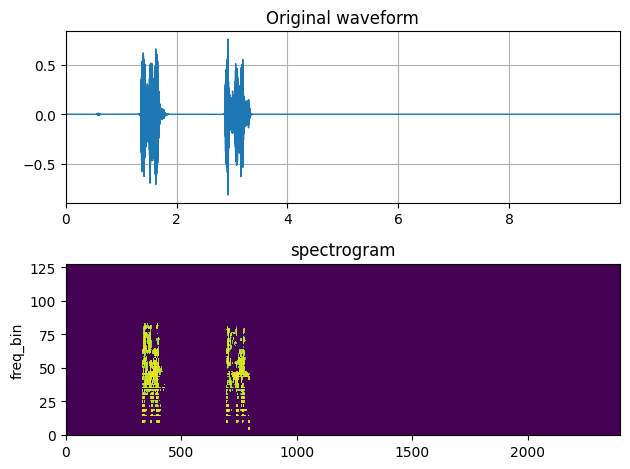

In [51]:
# Load the dataset
batch_size = 32

dataset = CovidCoughDataset('./Data/Dataset.xlsx', './Outputs/')
print(dataset[0][0].shape)
print(dataset.visual_spectrogram(300))
train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [52]:
class CovidClassifer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=3)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=3)

        # Fully connected layers
        # Note: Each spectrogram is 128 x 2400. We divide by 9 as there are two 3 by 3 kernels with stride 1 and padding 1. 
        self.fc1 = nn.Linear(64 * (128//27) * (2400//27), 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        # Flattens the 2D images into 1D
        x = x.view(-1, 64 * (128//27) * (2400//27))
        x = self.fc1(x)
        
        return x

In [53]:
def evaluate(model, test_dataloader):
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize epoch loss and accuracy
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
    # Calculate epoch loss and accuracy
    total_loss /= len(test_dataloader)
    accuracy = correct/total
    
    return total_loss, accuracy

In [54]:
def train(model, train_dataloader, valid_dataloader, epochs = 10, lr = 0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        
        model.train()
        
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_number, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_dataloader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
    
        epoch_loss, epoch_acc = evaluate(model, valid_dataloader)    
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Validation loss: {epoch_loss:.4f}, Validation accuracy: {epoch_acc:.4f}')
        torch.save(model.state_dict(),f"model_iter{epoch}.pt")            
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [55]:
model = CovidClassifer().to(device)

train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, epochs = 2, lr = 0.001)

Epoch 1/2, Batch number: 0, Cumulated accuracy: 0.5


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 39321600 bytes.

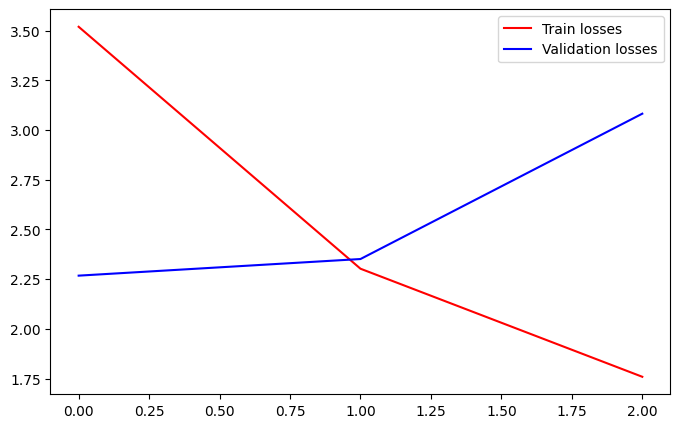

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train_losses, "r-", label = "Train losses")
plt.plot(valid_losses, "b-", label = "Validation losses")
plt.legend(loc = "best")
plt.show()

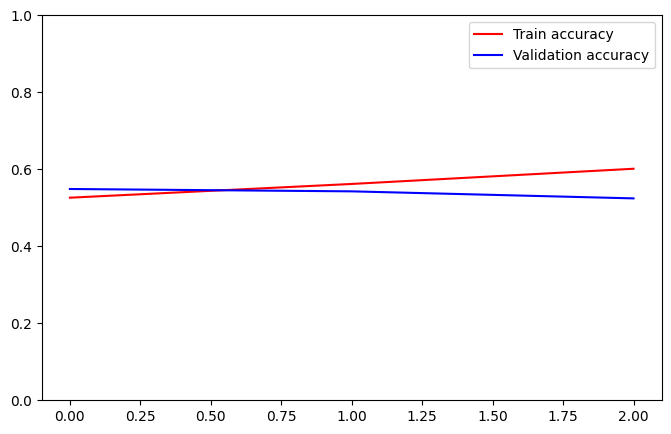

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(train_accuracies, "r-", label = "Train accuracy")
plt.plot(valid_accuracies, "b-", label = "Validation accuracy")
plt.legend(loc = "best")
plt.ylim([0, 1])
plt.show()

In [ ]:
loss, accuracy = evaluate(model, test_dataloader)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

Test loss: 2.4415, Test accuracy: 0.5122


In [ ]:
model.load_state_dict(torch.load("model_iter0"))
model.eval()

CovidClassifer(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=22528, out_features=2, bias=True)
)